# Data

In [1]:
import pandas as pd

In [2]:
file = 'fund_monthly_241229.csv'
path = '.'
df_prc = pd.read_csv(
    f'{path}/{file}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['group', 'ticker', 'date']
)

In [3]:
file = 'fund_name_241230.csv'
fund_name = pd.read_csv(f'{path}/{file}', dtype={'ticker': str}, index_col=[0]).iloc[:,0].to_dict()

In [4]:
calc_cagr = lambda year: (df_prc['price_after_fees']
                          .groupby('ticker', group_keys=False).apply(lambda x: x.pct_change(year*12).dropna())
                          .groupby('group').agg(['mean', 'std'])
                          .mul(100).round(1)
                          .apply(lambda x: f"{x['mean']:.1f} ± {x['std']:.1f}", axis=1)
                          #.apply(lambda x: f"{x['mean']:.1%} ± {x['std']:.1%}", axis=1)
                         )

df = (df_prc.groupby('group').apply(lambda x: x.index.get_level_values(1).nunique()).to_frame('n')
      .join(calc_cagr(1).rename('1y')).join(calc_cagr(3).rename('3y')))
df

,n,1y,3y
group,,,
2025,2,4.8 ± 8.4,12.6 ± 9.6
2030,12,4.9 ± 10.3,13.1 ± 11.0
2035,9,6.0 ± 11.6,16.6 ± 12.0
2040,9,6.5 ± 12.5,17.9 ± 12.7
2045,8,6.6 ± 13.1,17.9 ± 12.7
2050,6,6.8 ± 13.8,12.8 ± 10.4
2055,1,7.2 ± 10.9,23.1 ± 1.6


# Bayesian

In [5]:
from ddf_bayesian import BayesianEstimator

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
df_p = df_prc['price_after_fees'].droplevel(0).unstack('ticker')

In [7]:
freq_year = 3
days_in_year = 12 # months
freq = freq_year*days_in_year # months
date = '250109'

file_est = f'tdf_f{freq_year}y_{date}'
file_est

'tdf_f3y_250109'

## Estimate

In [8]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund_name
)
be = BayesianEstimator(df_p, **kw)

*Sample*

In [ ]:
be.bayesian_sample(freq=freq, file=file_est)

*Load*

In [11]:
be = BayesianEstimator.create(file_est, **kw)

./tdf_f3y_250109.pkl loaded


## Analysis

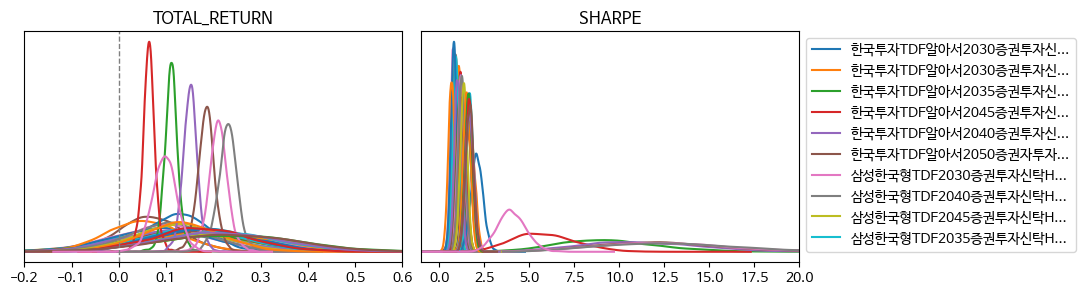

In [16]:
#xlims = None
xlims = [(-0.2, 0.6), (-1, 20)]
_ = be.plot_returns(max_legend=10, xlims=xlims)

In [17]:
#var_name = 'cagr'
var_name = 'total_return'
ms = ['mean','sd','hdi_3%','hdi_97%']
ascending = [False, True, False, False]

df_s = be.bayesian_summary(var_name).droplevel(0)
pick = lambda i, n=5, df=df_s: df.sort_values(ms[i], ascending=ascending[i]).iloc[:n].index.to_list()

In [18]:
#df_s.isna().any(axis=1).sum()
#df_s = df_s.dropna()

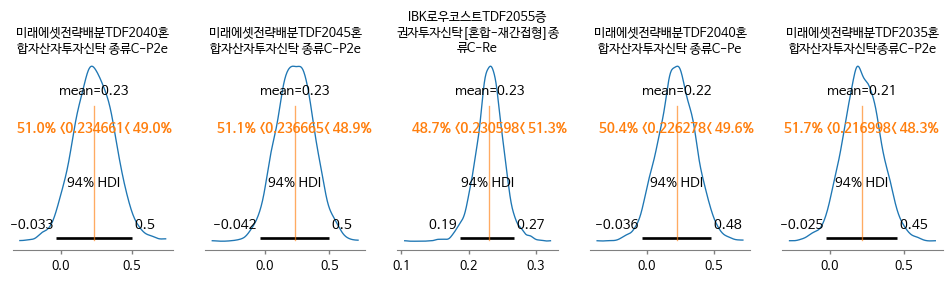

In [19]:
t0 = pick(0)
kw = dict(
    ref_val='default', 
    figsize=(12,2.5), textsize=9, grid=(1,5), length=16)
be.plot_posterior(var_name, t0, **kw)

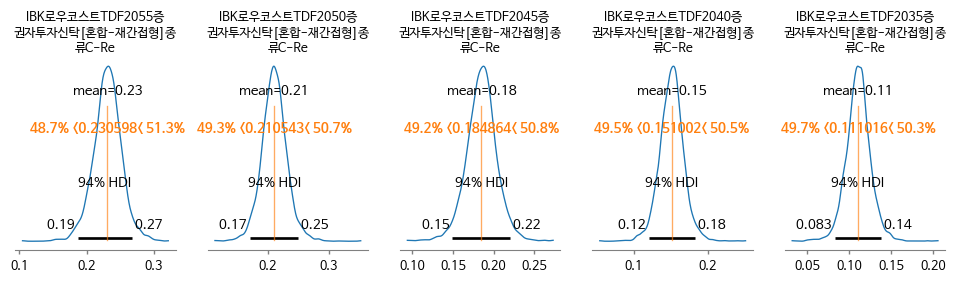

In [20]:
t2 = pick(2)
be.plot_posterior(var_name, t2, **kw)

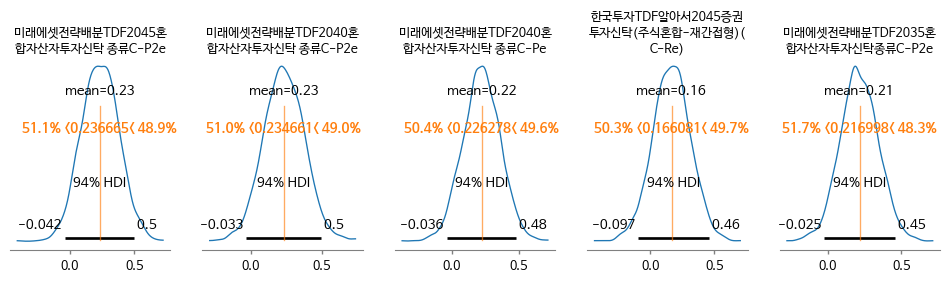

In [21]:
t3 = pick(3)
be.plot_posterior(var_name, t3, **kw)

*choice from frequentist stats*

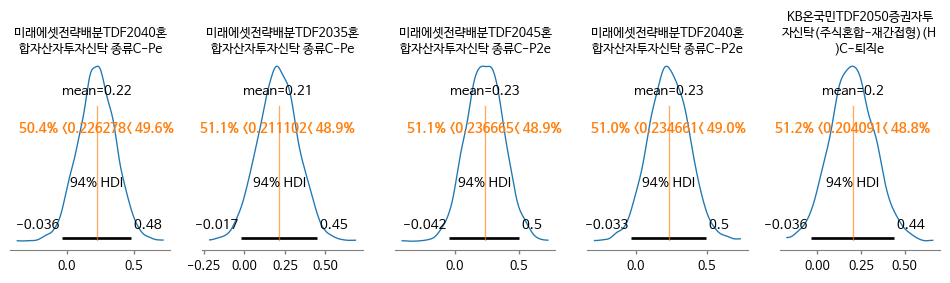

In [22]:
n = 5
t = be.get_stats(var_name).T.sort_values(var_name, ascending=False).iloc[:n].index.to_list()
be.plot_posterior(var_name, t, **kw)